In [3]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from utils import *
from plot import *
%load_ext autoreload
%autoreload 2

***Before starting, we recall the use of the gridworld environment.***

The gridworld environment is instantiated via the class `GridWorldEnvironment`. 

***It takes 4 input values:***
- `reward_mode` : Integer between 0 and 3 for different reward profiles,
- `size`: Gridworld size,
- `prop`: Probability assigned to the event that the agent does not follow the chosen action but another one selected uniformely at random,
- `gamma`: Discount factor of the environment.

***Interface of a Gridworld instance:***
- `print(gridworld.n_states)` # return the number of states
- `print(gridworld.n_actions)` # return the number of actions
- `print(gridworld.r)` # return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` # Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.

<img src="../dynamic_programming/src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

# Ex 1: Prove of the Policy Gradient Theorem via the Performance Difference Lemma (20 points)

Denote $J(\pi) = \langle \mu, V^\pi \rangle$ and recall that the performance difference lemma states
$$
J(\pi) - J(\pi') = \frac{1}{1 - \gamma}\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]
$$
where $\lambda^{\pi'} \in \Delta_{\mathcal{S}\times\mathcal{A}}$ denotes the occupancy measure of the policy $\pi'$.

Now let us consider direct parametization, and compute a partial derivative for the entry of $\pi$ at index $(\bar{s},\bar{a})$:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})}.
$$

**Questions**

To help you compute this partial derivative, consider the policies $\pi'$ parameterized by some (sufficiently small) $\delta \in \mathbb{R}$ via
$$
    \pi'(a|s) = \begin{cases}
        \pi(\bar{a}|\bar{s}) + \delta \quad (\text{if } (s,a)=(\bar{s},\bar{a}))\\
        \pi(a|s) \quad (\text{else})
    \end{cases}
$$

(1) Argue that
$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} =\lim_{\delta \rightarrow 0} \frac{(1-\gamma)^{-1}\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}.
$$

**Answer**

Let's start by making some observations. We can define the policy difference in the following way:
$$
\begin{align*}
    \pi(a|s) - \pi'(a|s) &= 
    \begin{cases}
        \pi(\bar{a}|\bar{s}) - (\pi(\bar{a}|\bar{s}) + \delta) \quad & \text{if } (s,a)=(\bar{s},\bar{a})\\
        \pi(a|s) - \pi(a|s) \quad & \text{otherwise}
    \end{cases}\\
    &=
    \begin{cases}
        - \delta \quad & \text{if } (s,a)=(\bar{s},\bar{a})\\
        0 \quad & \text{otherwise}
    \end{cases}
\end{align*}
$$
We can also remind ourselves of the definition of the derivative as a limit:
$$
\frac{\partial f(x)}{\partial x} = \lim_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h}
$$
Now using these observations we can 
$$
\begin{align*}
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} 
&= \lim_{\delta \rightarrow 0}\frac{J(\pi + \delta) - J(\pi)}{\delta}\\
&= \lim_{\delta \rightarrow 0}\frac{J(\pi') - J(\pi)}{\pi'(\bar{a}|\bar{s}) - \pi(\bar{a}|\bar{s})}\\
&= \lim_{\delta \rightarrow 0}\frac{(1-\gamma)^{-1}\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}
\end{align*}
$$

(2) Argue that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} (1-\gamma)^{-1}\lambda^{\pi'}(\bar{s}) Q^\pi(\bar{s}, \bar{a}).$$

Hint: Write the expectation in the previous question as a sum and use the fact that $\frac{\pi(a|s) - \pi'(a|s)}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})} = \mathbf{1}_{\{ (\bar{s},\bar{a}) = (s,a) \}}$.

**Answer**

We start by expressing the expectation found on the numerator as a sum:

$$
\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle] = \sum_s \lambda_\mu^{\pi'}(s)\langle\pi(a|s) - \pi'(a|s), Q^\pi\rangle
$$

Now if we plug this expression in the result of (1) (and considering that $(\bar{s},\bar{a}) = (s,a)$) one can find:

$$
\begin{align*}
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} 
&= \lim_{\delta \rightarrow 0}\frac{(1-\gamma)^{-1}\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})} \\
&= \lim_{\delta \rightarrow 0}(1-\gamma)^{-1}\sum_s \lambda_\mu^{\pi'}(s)\left\langle\frac{\pi(a|s) - \pi'(a|s)}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}, Q^\pi(s,a)\right\rangle\\
&= \lim_{\delta \rightarrow 0}(1-\gamma)^{-1} \sum_s\lambda_\mu^{\pi'}(s)\left\langle\mathbf{1}_{(\bar{s},\bar{a}) = (s,a)}, Q^\pi(s,a)\right\rangle\\
&= \lim_{\delta \rightarrow 0}(1-\gamma)^{-1} \lambda_\mu^{\pi'}(\bar{s}) Q^\pi(\bar{s},\bar{a})\\
\end{align*}
$$

(3) Conclude that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = (1-\gamma)^{-1}\lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a})$$
for the direct parameterization. 

**Answer**

As $\delta$ approaches zero we have that $\pi(a|s) \rightarrow \pi'(a|s)$ therefore we can simply rewrite the previous expression in the following way:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})}
= \lim_{\delta \rightarrow 0}(1-\gamma)^{-1} \lambda_\mu^{\pi'}(\bar{s}) Q^\pi(\bar{s},\bar{a})
= (1-\gamma)^{-1}\lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a})
$$

(4) Prove that for a general parametrization, it holds that
$$
\nabla_\theta J(\pi_\theta) = \sum_{\bar{s},\bar{a}} (1-\gamma)^{-1}\lambda^{\pi}(\bar{s}, \bar{a}) Q^\pi(\bar{s}, \bar{a}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s}))
$$

Hint: Use the chain rule to write $$ \nabla_\theta J(\pi_\theta)  = \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s}), $$
and then use the fact that $\lambda^{\pi}(\bar{s},\bar{a}) = \lambda^{\pi}(\bar{s}) \pi(\bar{a}|\bar{s})$.

**Answer**

We can start by recolecting the reformulation of a function using the logarithm trick:
$$
\nabla_\theta \log f(\theta) = \frac{1}{f(\theta)} \cdot \nabla_\theta f(\theta)
$$

Now we can start working towards the solution:
$$
\begin{align*}
\nabla_\theta J(\pi_\theta)  
&= \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s})\\
&= \sum_{\bar{s},\bar{a}} (1-\gamma)^{-1}\lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a}) \pi_\theta(\bar{a}|\bar{s})\nabla_{\theta} \log\pi_\theta(\bar{a}|\bar{s})\\
&= \sum_{\bar{s},\bar{a}} (1-\gamma)^{-1}\lambda^{\pi}(\bar{s}, \bar{a}) Q^\pi(\bar{s}, \bar{a}) \nabla_{\theta} \log\pi_\theta(\bar{a}|\bar{s})\\
\end{align*}

# Ex 2: Natural Policy Gradient with softmax parameterization (30 points)

Recall that the iterates $\{\pi^t\}^{\infty}_{t=1}$ produced by NPG read as follows:
$$
\pi^{t+1}(a|s) = \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}.
$$

**Question** 

Implement NPG for an arbitrary step size $\eta$.

In [4]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy stochastic passed with shape n_states times n_actions
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s].dot(pi[s])
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

def npg_update(q, eta, old_policy):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        new_policy: the updates policy
    """
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        # print(f"{q[s] = }")
        # print(f"{eta * q[s] = }")
        # print(f"{old_policy[s] = } \n{np.exp(eta * q[s]) = }")
        policy[s] = old_policy[s] * np.exp(eta * q[s])  # TODO (unnormalized update)
        policy[s] = policy[s] / np.sum(old_policy[s] + 1e-10) # TODO: normalize
    return policy

def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        policy[s,np.argmax(q[s,:])] = 1
    return policy

In [5]:
def NPG(env, eta): # apply NPG iterations for 30 steps
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.ones_like(q)/env.n_actions
    for k in range(30):
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env)
        if eta < np.inf:
            
            pi = npg_update(q, eta, pi)
        else:
            pi = get_greedy_policy(q)
        vs.append(v)
        policies.append(pi)
    return vs, policies

Now, we run NPG for different stepsizes in the usual gridworld environment

In [6]:
reward_mode = 2
size = 10 
prop = 0
gamma = 0.99
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
mu = np.ones(gridworld.n_states)/gridworld.n_states
etas = [1e-3, 1e-2, 1e-1, 1, 100, 1e7, np.inf]

v_different_etas = []
pi_different_etas = []
for eta in etas:
    print(f"Running NPG with eta={eta}")
    values_pi, policies = NPG(gridworld, eta=eta)
    v_different_etas.append(values_pi)
    pi_different_etas.append(policies)

Running NPG with eta=0.001
Running NPG with eta=0.01
Running NPG with eta=0.1
Running NPG with eta=1
Running NPG with eta=100
Running NPG with eta=10000000.0
Running NPG with eta=inf


In [7]:
solver = MDPsolver(gridworld)
solver.value_iteration()

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


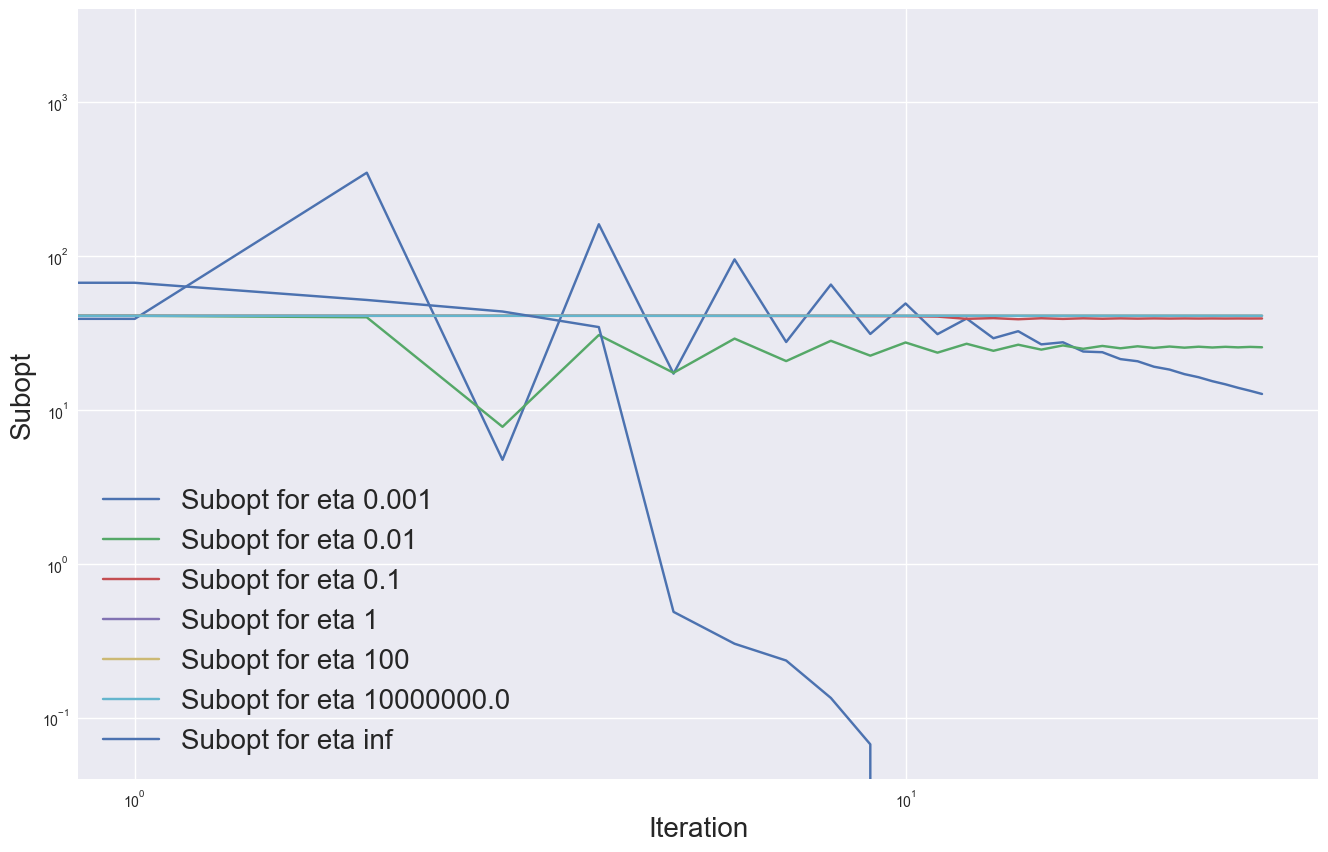

In [29]:
# TODO: if this plot appears with a too large legend, rerun this line once more
plot_log_lines([np.array([np.abs(mu.dot(solver.v - v)) for v in v_different_etas[i]]) for i, _ in enumerate(etas)], [f"Subopt for eta {eta}" for eta in etas], ["Iteration", "Subopt"], "figs", "NPG.pdf", show = True)

**Question**

Show that NPG with $\eta = \infty$ coincides with Policy Iteration (PI).

More formally: Assuming that $a^\star_s := \mathrm{argmax}_a Q^{\pi^t}(s,a)$ is unique for all $s$, prove that $$ \lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} = \begin{cases} 1 \quad \text{if} \quad a = a^\star_s \\ 0 \quad \text{otherwise} \end{cases},$$
and explain how this relates to PI.

**Answer**

We know that for a given $s$ the Q-value associated to $a_s^\star$ is the greatest wrt to $a$. So applying the limit the only way to get a non-zero value is to plug in $a^\star_s$ to have the optimal value of $Q$.

$$
\begin{align*}
\lim_{\eta\rightarrow\infty}\frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}
&= \lim_{\eta\rightarrow\infty}\frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{ \pi^t(a^\star_s|s) e^{\eta Q^{\pi^t}(s,a^\star_s)} + \sum_{a' \neq a^\star_s}\pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}
\end{align*}
$$

If $a = a^\star_s$ then we have the following expression:

$$
\lim_{\eta\rightarrow\infty}\frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{ \pi^t(a^\star_s|s) e^{\eta Q^{\pi^t}(s,a^\star_s)} + \sum_{a' \neq a^\star_s}\pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}
$$
Where the "largest" term of both the denominator and the numerator are equal leading to a result equal to $1$. In all other cases the greatest (and only) value of the numerator is not matching the magnitude of the largest value fo the denominator since $Q^{\pi^t}(s, a^\star_s) > Q^{\pi^t}(s,a) \quad\forall a\in\mathcal{A}\setminus\{a^\star_s\}$ resulting to a $0$.

**Question**

Is this observation in line with the empirical results in the plot above? I.e., is the plot for $\eta = \infty$ as you would expect it for PI?

**Answer**

Yes, if we remember the plot we generated in Assignment 1 Part 1.3 for the PI we have a curve with a very similar shape 

# Ex 2.1 Slow Changing Property of NPG

In this exercise you will investigate by how much consecutive iterates $\pi^t$ and $\pi^{t+1}$ produced by NPG differ and how this distance is controlled by the step size $\eta$.

Plot $$\max_{s \in \mathcal{S}} || \pi^{t+1}(a|s) - \pi^t(a|s) ||_1$$ for different values of $\eta$.

In [10]:
def compute_policy_variation(policies):
    variation = []
    for pi, pip in zip(policies[1:], policies[:-1]):
        variation.append(np.max([ np.abs(pi[s] - pip[s]) for s in range(pi.shape[0])])) # TODO
    return variation

c:\Users\arist\EPFL\MA4\Reinforcement Learning\Assignment3\src\plot.py:160: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


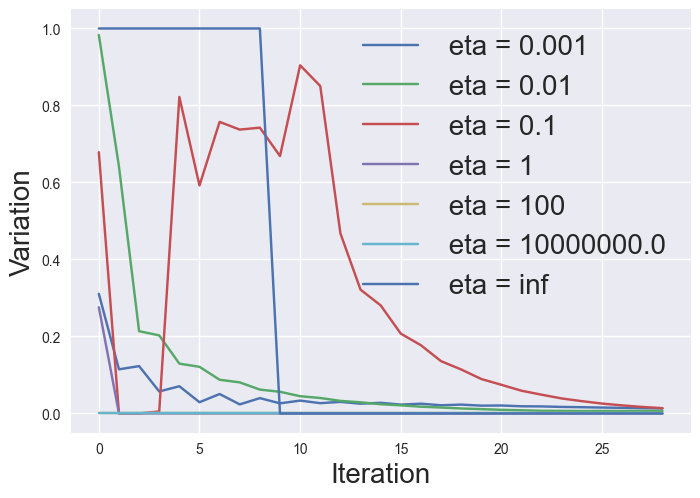

In [30]:
plot_lines(np.array([ compute_policy_variation(np.array(pi_different_etas)[i])
                           for i, _ in enumerate(etas)]), 
               [f" eta = {eta}" for eta in etas], 
               ["Iteration", "Variation"], "figs", "NPG.pdf", show = True)

**Question**

Empirically, is the largest change (among all iterations) between consecutive iterations larger for smaller or large values of $\eta$?

The smallest jump between two iterations is observed for lower values of $\eta$ whereas for larger $\eta$ s we can see large jumps like the extreme case where $\eta \rightarrow \infty$

## Some Theory to Motivate the Observation Above

**Question**

Our goal is to prove that $$ || \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) ||_1 \leq \frac{\eta}{1 - \gamma} \quad \forall s \in \mathcal{S}, \forall t \in [T].$$

We guide you towards this result by breaking the proof into small steps.

1) Prove that $$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg) $$

Hint: First apply Pinkser's inequality https://en.wikipedia.org/wiki/Pinsker%27s_inequality to prove that $$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq KL(\pi^{t+1}(s)||\pi^t(s)), $$ then plug in the formula for $\pi^{t+1}$ into the KL term.

**Answer**

Let's start by stating Pinkster's inequality:
$$
\delta(P,~Q) \leq\sqrt{2D_{KL}(P||Q)}, \quad \text{with}\quad D_{KL}(P||Q) = \mathbb{E}_P\left[\log\frac{\partial P}{\partial Q}\right]
$$
Now if we apply it to our case we have:
$$
\delta(P=\pi^{t+1}(s),~Q=\pi^t(s)) = ||\pi^{t+1}(s) - \pi^{t}(s)||_1 \leq\sqrt{2D_{KL}(\pi^{t+1}(s)||\pi^{t}(s))}
$$

$$
\begin{align*}
\frac{1}{2}||\pi^{t+1}(s) - \pi^{t}(s)||_1^2 &\leq D_{KL}(\pi^{t+1}(s)||\pi^{t}(s))\\
&= \mathbb{E}_{\pi^{t+1}}\left[\log\frac{\partial \pi^{t+1}(s)}{\partial \pi^{t}(s)}\right]
\end{align*}
$$

For the policy update we have:
$$
\pi^{t+1}(a|s) = \frac{\pi^t(a|s)\exp\left(\eta Q^{\pi^t}(s,a)\right)}{c}, \quad \text{with}\quad c = \sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp \left(\eta Q^{\pi^t}(s,a')\right)
$$
and
$$
\frac{\partial \pi^{t+1}(s)}{\partial \pi^{t}(s)} = \frac{1}{c}\exp\left(\eta Q^{\pi^t}(s,a)\right)
$$

Now we can continue the derivation:
$$
\begin{align*}
\frac{1}{2}||\pi^{t+1}(s) - \pi^{t}(s)||_1^2 &\leq \mathbb{E}_{\pi^{t+1}}\left[\log\frac{\partial \pi^{t+1}(s)}{\partial \pi^{t}(s)}\right]\\
&= \mathbb{E}_{\pi^{t+1}}\left[\log\left(\frac{1}{c}\exp\left(\eta Q^{\pi^t}(s,a)\right)\right)\right]\\
&= \mathbb{E}_{\pi^{t+1}}\left[\eta Q^{\pi^t}(s,a)\right] - \log \left(\underbrace{\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))}_c\right)
\end{align*}
$$

2) Prove that 
$$
\sum_{a\in \mathcal{A}} \pi^{t+1}(a|s) \exp(- \eta Q^{\pi^t}(s,a)) = \frac{1}{\sum_{a'\in \mathcal{A}} \pi^t(a|s) \exp(\eta Q^{\pi^t}(s,a) )}.
$$

**Answer**

$$
\begin{align*}
\sum_{a\in \mathcal{A}} \pi^{t+1}(a|s) \exp(- \eta Q^{\pi^t}(s,a)) 
&= \sum_{a\in \mathcal{A}} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) \exp(\eta Q^{\pi^t}(s,a'))} \exp(- \eta Q^{\pi^t}(s,a))\\
&= \sum_{a\in \mathcal{A}} \frac{\pi^t(a|s)}{\sum_{a'} \pi^t(a'|s) \exp(\eta Q^{\pi^t}(s,a'))}\\
&=  \frac{1}{\sum_{a'} \pi^t(a'|s) \exp(\eta Q^{\pi^t}(s,a'))}\\
\end{align*}
$$

3) Using the results in 1) and 2) prove that 

$$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg). $$

**Answer**

From the equation previously found we have:
$$
\begin{align*}
\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 &\leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg)\\
&= \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \left(\frac{1}{\sum_{a'\in \mathcal{A}} \pi^{t+1}(a'|s) \exp(- \eta Q^{\pi^t}(s,a'))}\right)\\
&= \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \left(\sum_{a'\in \mathcal{A}} \pi^{t+1}(a'|s) \exp(- \eta Q^{\pi^t}(s,a'))\right)
\end{align*}
$$

4) Using Hoeffding's Lemma https://en.wikipedia.org/wiki/Hoeffding%27s_lemma (on the sum in the log term!) and the fact that $$-\frac{1}{1-\gamma} \leq Q^{\pi^t}(s,a) \leq \frac{1}{1-\gamma},$$ conclude that 
$$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \frac{\eta^2}{2 (1 - \gamma)^2}.$$

**Answer**

We can start by reformulating the sum we have in our previously found expression:
$$
\sum_{a'\in \mathcal{A}} \pi^{t+1}(a'|s) \exp(- \eta Q^{\pi^t}(s,a')) = \mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}\left[\exp(- \eta Q^{\pi^t}(s,a'))\right]
$$
Now using Hoeffding's lemma with $X = Q^{\pi^t}(s,a)$, $\lambda = -\eta$ and $a = -\frac{1}{1-\gamma} \text{~and~} b = \frac{1}{1-\gamma}$ we find:
$$
\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}\left[\exp(- \eta Q^{\pi^t}(s,a'))\right] \leq \exp\left(-\eta\mathbb{E}[Q^{\pi^t}(s,a')] + \frac{4\eta^2}{8(1 - \gamma)^2}\right)
$$

Pluging this back into our original equation we obtain the desired result:
$$
\begin{align*}
\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 
&\leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \left(\sum_{a'\in \mathcal{A}} \pi^{t+1}(a'|s) \exp(- \eta Q^{\pi^t}(s,a'))\right)\\
&\leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \left(\exp\left(-\eta\mathbb{E}[Q^{\pi^t}(s,a')] + \frac{\eta^2}{2(1 - \gamma)^2}\right)\right)\\
&= \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)]  -\mathbb{E}[\eta Q^{\pi^t}(s,a')] + \frac{\eta^2}{2(1 - \gamma)^2}\\
&= \frac{\eta^2}{2(1 - \gamma)^2}
\end{align*}
$$

So we indeed have:
$$
\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \frac{\eta^2}{2(1 - \gamma)^2}
$$

# Ex 3: OPPO: The importance of Exploration in Policy Gradient (30 points)

In this exercise, we will investigate how crucial it is to perform exploration. That is, adding bonuses to avoid suffering the mismatch coefficients in the convergence bounds.

Let us recall that the standard sample based version of NPG suffers the mismatch coeffcients in the bounds (see Slide 22 in Lecture 5). Those are avoided by OPPO ( See slide 30 in Lecture 5 ).

**To see clearly the advatange of OPPO we will consider an MDP with unbounded mismatch coefficients**

**Question: example of unbounded mismatch coefficients**

Consider a 10 x 10 gridworld, the initial state is always the bottom right corner, i.e. the initial distribution $\mu$ equals $1$ at this starting state and it is zero everywhere else. Can you compute a finite bound for 
$$\max_\pi \max_{s \in \mathcal{S}} \bigg |\frac{\lambda^\pi(s)}{\mu(s)} \bigg|,$$
i.e. the mismatch coefficient? If not, argue for which reason.

**Answer**



Since $\mu(s) = 0$ for all states $s$ except one, for any state $s$ other than the initial state, the denominator will be zero and therefore the fraction will be underdined. Therefore we cannote compute the finite bound for the mismatch coefficient $\kappa$.

This showcases a situation where standard approaches like NPG do not work duw to mismatche in the bounds. An algorithm like OPPO which adds exploration bonuses, is prefered as it does not depend on $\kappa$.

In the following, we experiment with OPPO with and without bonuses in this environment.

In [12]:
reward_mode = 0
size = 10
gamma = 0.999
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

In [13]:
def oppo(K: int = 10000, H: int = 20, beta: float = 0.0001, eta=10000) -> List[float]:
    """
    Function implementing OPPO with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param beta: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))

    policy = H * np.ones((H, gridworld.n_states, gridworld.n_actions))/gridworld.n_actions

    V[H, :] = 0
    estimated_transitions = np.ones((H, gridworld.n_states, 
                                     gridworld.n_actions, 
                                     gridworld.n_states))/gridworld.n_states
    N = np.zeros((H, gridworld.n_states, gridworld.n_actions))
    N_next = np.zeros((H, gridworld.n_states, gridworld.n_actions, gridworld.n_states))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # NPG Update
            policy[h, state, :] = policy[h, state, :] * np.exp(eta * Q[h, state, :]) # TODO (unnormalized)
            policy[h, state, :] /= np.sum(policy[h, state, :]) + 1e-10 # TODO: normalize
            # Sample one action the current policy
            a = np.random.choice(gridworld.n_actions, p=policy[h, state, :]) # TODO
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1 # TODO

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])
            N_next[h, state, a, new_state] += 1 # TODO
            
            estimated_transitions[h,state,a,:] = N_next[h, state, a, :] / N[h, state, a] # TODO
            

            # Calculate the UCB bonus
            bonus = beta * np.sqrt(H ** 3 / N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = np.clip(gridworld.r[state, a] + bonus + np.sum(estimated_transitions[h, state, a, :] * V[h + 1, :]), 0, H) # TODO

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :]) # TODO

            state = new_state

    return rewards

In [14]:
to_plot = []
betas = [0, 1e-5, 1e-4, 1e-3, 1e-1]

for beta in betas:
    print(f"Running OPPO with beta={beta}")
    reward_OPPO = oppo(beta = beta, eta=10)  # You can play around with the arguments if you like
    to_plot.append(np.cumsum(reward_OPPO))

Running OPPO with beta=0
Running OPPO with beta=1e-05
Running OPPO with beta=0.0001
Running OPPO with beta=0.001
Running OPPO with beta=0.1


In [15]:
to_plot[4]

array([0., 0., 0., ..., 0., 0., 0.])

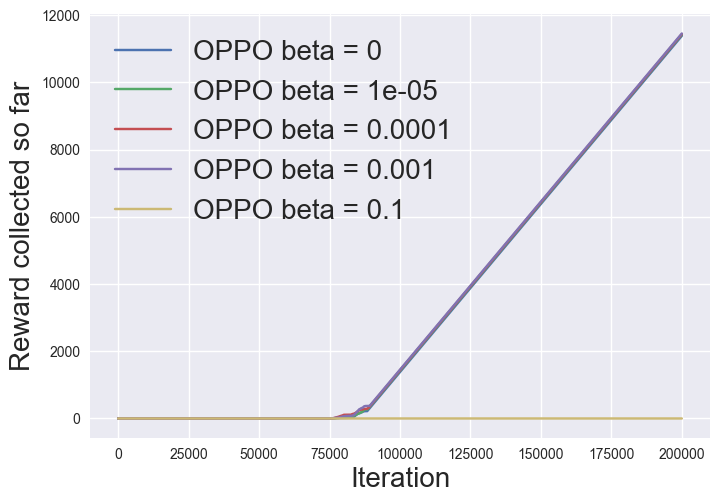

In [16]:
labels = [ f"OPPO beta = {beta}" for beta in betas]
plot_lines(
    to_plot,
    labels,
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=True
)

_**Note: The resulting plot is probably wrong since we expect the cases where we ignore either exploration or exploitation to yield worse results, which is not what we observe, on the contrary ($\beta = 0$) which is purely exploitative results in one of the best results.**_

**Question**

Why does setting $\beta = 0$ lead to bad results? 

*Hint: Explain using the remarks in slide 28 and the theoretical bound in Slide 22 of Lecture 5*.

**Answer**

A $\beta$ equal to zero corresponds to an approach that avoids exploration and is equivalent to a greedy algorithm

**Question**

Why does setting $\beta$ too large lead to poor results?

*Hint: Answer using the regret bound for OPPO given at the beginning of slide 30.*

**Answer**

A $\beta$ too large corresponds to an algorithm "over-focusing" on exploration and not taking advantage of the knowledgw aquired in previous episodes 

# Ex 4: REINFORCE with parametrized policies (20 points)

In this exercise, we will investigate the effect of choosing different baselines in the reinforce implementation.
This topic is covered from Slide 31 on in Lecture 5.

**Hint: You may want to use Google Colab to run the experiments faster, but you don't have to.**

### Import the Necessary Packages

In [17]:
# TODO: you may need to run this to make sure to have the correct versions
!pip install gym==0.25.2
!pip install gym-notices==0.0.8

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the Environment and Agent

The CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space.

In [20]:
env = gym.make('CartPole-v0')
env.seed(0)

C:\Users\arist\AppData\Roaming\Python\Python39\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\arist\AppData\Roaming\Python\Python39\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\arist\AppData\Roaming\Python\Python39\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\arist\AppData\Roaming\Python\Python39\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked 

[0]

In [21]:
class Policy(nn.Module): # definie the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

In [22]:
# REINFORCE (with reward-to-go)
# --> with gradient estimator according to version 2 of the PG theorem (not using Q-values, but reward to go)
def reinforce_rwd2go(policy, optimizer, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G = rewards_to_go[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

**Question**

1. Find **two** good baselines that improve over the implementation of REINFORCE without baseline. You should plot their results below.

You can take inspiration from the Example Notebook we attached for lecture 4, but you **cannot use exactly the same**.

2. Explain why you chose your baselines and why you think they are reasonable.

*Note:* You may also change other parameters such as the learning rate, as long as you clearly state it in your response.

**Answer**

**Baseline 1**

This baseline calculates a value based on the pole's angle and angular velocity (complementing the naive baseline). It penalizes large angles, which corespond to unstable states. It also introduces a penalty when the angular velocity and the angle have the same sign, as this indicates that the pole is being pushed towards the ground.

**Baseline 2**

This baseline uses exponential decay for deviations in angle and angular velocity from zero. The exponential decreases rapidly as the absolute value of the variable increases, which penalizes more states that deviate from the verical position or move too fast. The constants reflect the relative importance of the varaibles. 

In [26]:
def naive_baseline(state): # Example Baseline from lecture 4 (for inspiration)
  # Idea: a large angle (among other things) is bad; so V(s) should be correlated with, e.g., -100*angle**2
  angle = state[2]
  value = 100*(0.25-angle**2) # TO BE CHANGED USING YOUR BASELINE
  return value

def baseline_1(state): # TO BE CHANGED USING YOUR BASELINE 1
  # penalize if the angular velocity has the same sign as the angle
  angle = state[2]
  angular_velocity = state[3]
  value = 100*(0.25-angle**2) - 10*angle*angular_velocity # TO BE CHANGED USING YOUR BASELINE
  return value # TODO

def baseline_2(state): # TO BE CHANGED USING YOUR BASELINE 2
  angle, angular_velocity = state[2], state[3] # TODO
  return -200 * np.exp(-np.abs(angle)) - 100 * np.exp(-np.abs(angular_velocity)) # TODO

# PLOT 3: reward-to-go with baseline REINFORCE
# --> with gradient estimator according to version 3 of the PG theorem (not using Q-values, but reward to go)
# --> here, we consider only fixed (handcrafted) baseline functions b : S -> R; clearly, training a NN to predict V^{\pi}(s) as a baseline is also possible (and interesting!)
def reinforce_rwd2go_baseline(policy, optimizer, early_stop=False, baseline=naive_baseline, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        baseline_values = []
        # MINE
        running_avg_rewards = 0
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            baseline_values.append(baseline(state))
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G_centered = rewards_to_go[i] - baseline_values[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G_centered)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [27]:
env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 1: run REINFORCE
policy_rwd2go = Policy().to(device)
optimizer_rwd2go = optim.Adam(policy_rwd2go.parameters(), lr=1e-2)
scores_rwd2go = reinforce_rwd2go(policy_rwd2go, optimizer_rwd2go, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 2: run REINFORCE and YOUR baseline 1
policy_baseline_1 = Policy().to(device)
optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, baseline=baseline_1, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 3: run REINFORCE and YOUR baseline 2
policy_baseline_2 = Policy().to(device)
optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)
scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, baseline=baseline_2, early_stop=False, n_episodes=2000)



Episode 100	Average Score: 70.85
Episode 200	Average Score: 163.02
Episode 300	Average Score: 159.67
Episode 400	Average Score: 199.76
Episode 500	Average Score: 170.70
Episode 600	Average Score: 140.34
Episode 700	Average Score: 180.00
Episode 800	Average Score: 166.98
Episode 900	Average Score: 172.96
Episode 1000	Average Score: 187.00
Episode 1100	Average Score: 198.93
Episode 1200	Average Score: 146.44
Episode 1300	Average Score: 138.97
Episode 1400	Average Score: 199.42
Episode 1500	Average Score: 196.28
Episode 1600	Average Score: 158.22
Episode 1700	Average Score: 199.87
Episode 1800	Average Score: 188.06
Episode 1900	Average Score: 183.53
Episode 100	Average Score: 56.33
Episode 200	Average Score: 144.66
Episode 300	Average Score: 162.76
Episode 400	Average Score: 141.17
Episode 500	Average Score: 159.75
Episode 600	Average Score: 137.67
Episode 700	Average Score: 115.16
Episode 800	Average Score: 125.71
Episode 900	Average Score: 157.97
Episode 1000	Average Score: 116.29
Episo

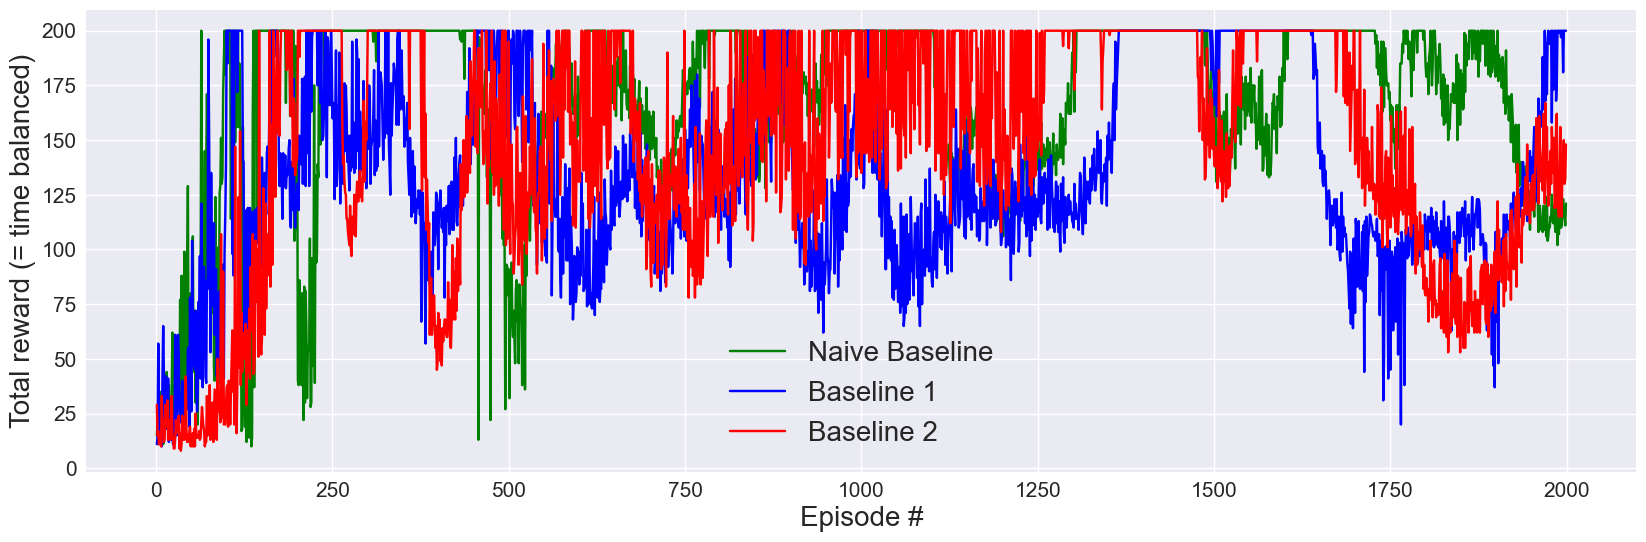

In [28]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='Naive Baseline')
ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()